# Importing necessary libraries

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Reading the dataset for the Stock HBL Power

In [ ]:
df= pd.read_csv('/content/HBLS Historical Data.csv')
df.drop(["Open", "High", "Low", "Vol.", "Change %"], inplace=True, axis= 1)
df

,Date,Price
0,01/23/2024,452.00
1,01/20/2024,483.90
2,01/19/2024,488.35
3,01/18/2024,478.60
4,01/17/2024,461.65
...,...,...
754,01/07/2021,37.95
755,01/06/2021,37.85
756,01/05/2021,39.15
757,01/04/2021,39.25


In [ ]:
df_reversed = df[::-1].reset_index(drop=True)
df_reversed1= df_reversed
df_reversed.dtypes

Date      object
Price    float64
dtype: object

# Calculating Simple Moving Average

In [ ]:
# Calculating Simple Moving Average

def SMA(data, period):
  return pd.Series(data.rolling(window= period).mean())

df_reversed['SMA'] = SMA(df_reversed['Price'] , 50)

In [ ]:
df_reversed

,Date,Price,SMA
0,01/01/2021,39.75,NaN
1,01/04/2021,39.25,NaN
2,01/05/2021,39.15,NaN
3,01/06/2021,37.85,NaN
4,01/07/2021,37.95,NaN
...,...,...,...
754,01/17/2024,461.65,401.439
755,01/18/2024,478.60,404.821
756,01/19/2024,488.35,408.511
757,01/20/2024,483.90,412.123


# Calculating Exponential Moving Average

In [ ]:
def EMA(data, period):
  return pd.Series(data.ewm(span= period , min_periods= period).mean())

df_reversed['EMA'] = EMA(df_reversed['Price'] , 50)
df_reversed['EMA20'] = EMA(df_reversed['Price'] , 20)

#Calculating Moving Average Convergence Divergence

In [ ]:
def MACD(df_reversed, fast_period, slow_period, signal_period = 9):

  ema1= EMA(df_reversed['Price'] , slow_period)                                 # getting 26 day EMA
  ema2= EMA(df_reversed['Price'] , fast_period)                                 # getting 12 day EMA

  df_reversed['MACD'] = ema2 - ema1
  df_reversed['signal'] = EMA(df_reversed['MACD'] , signal_period)              # getting 9 day EMA of MACD
  df_reversed['histogram'] = pd.Series(df_reversed['MACD'] - df_reversed['signal'])

MACD(df_reversed, 12, 26)

# Calculating Relative Strength Index

In [ ]:
def RSI(data, period):

    delta = data.diff()
    delta = delta[1:]

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window= period).mean()
    avg_loss = loss.rolling(window= period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df_reversed['RSI'] = RSI(df_reversed['Price'] , 14)

# Getting the Lower Bands and Upper Bands for Bollinger Bands.

In [ ]:
def BollingerBands(df_reversed, period=20):

    df_reversed['SMA20'] = SMA(df_reversed['Price'] , period)
    std = df_reversed['Price'].rolling(period).std()
    df_reversed['bb'] = df_reversed['SMA20'] + std * 2
    df_reversed['lower_band'] = df_reversed['SMA20'] - std * 2

BollingerBands(df_reversed)

#Visualizing the indicators w.r.t Closing Price



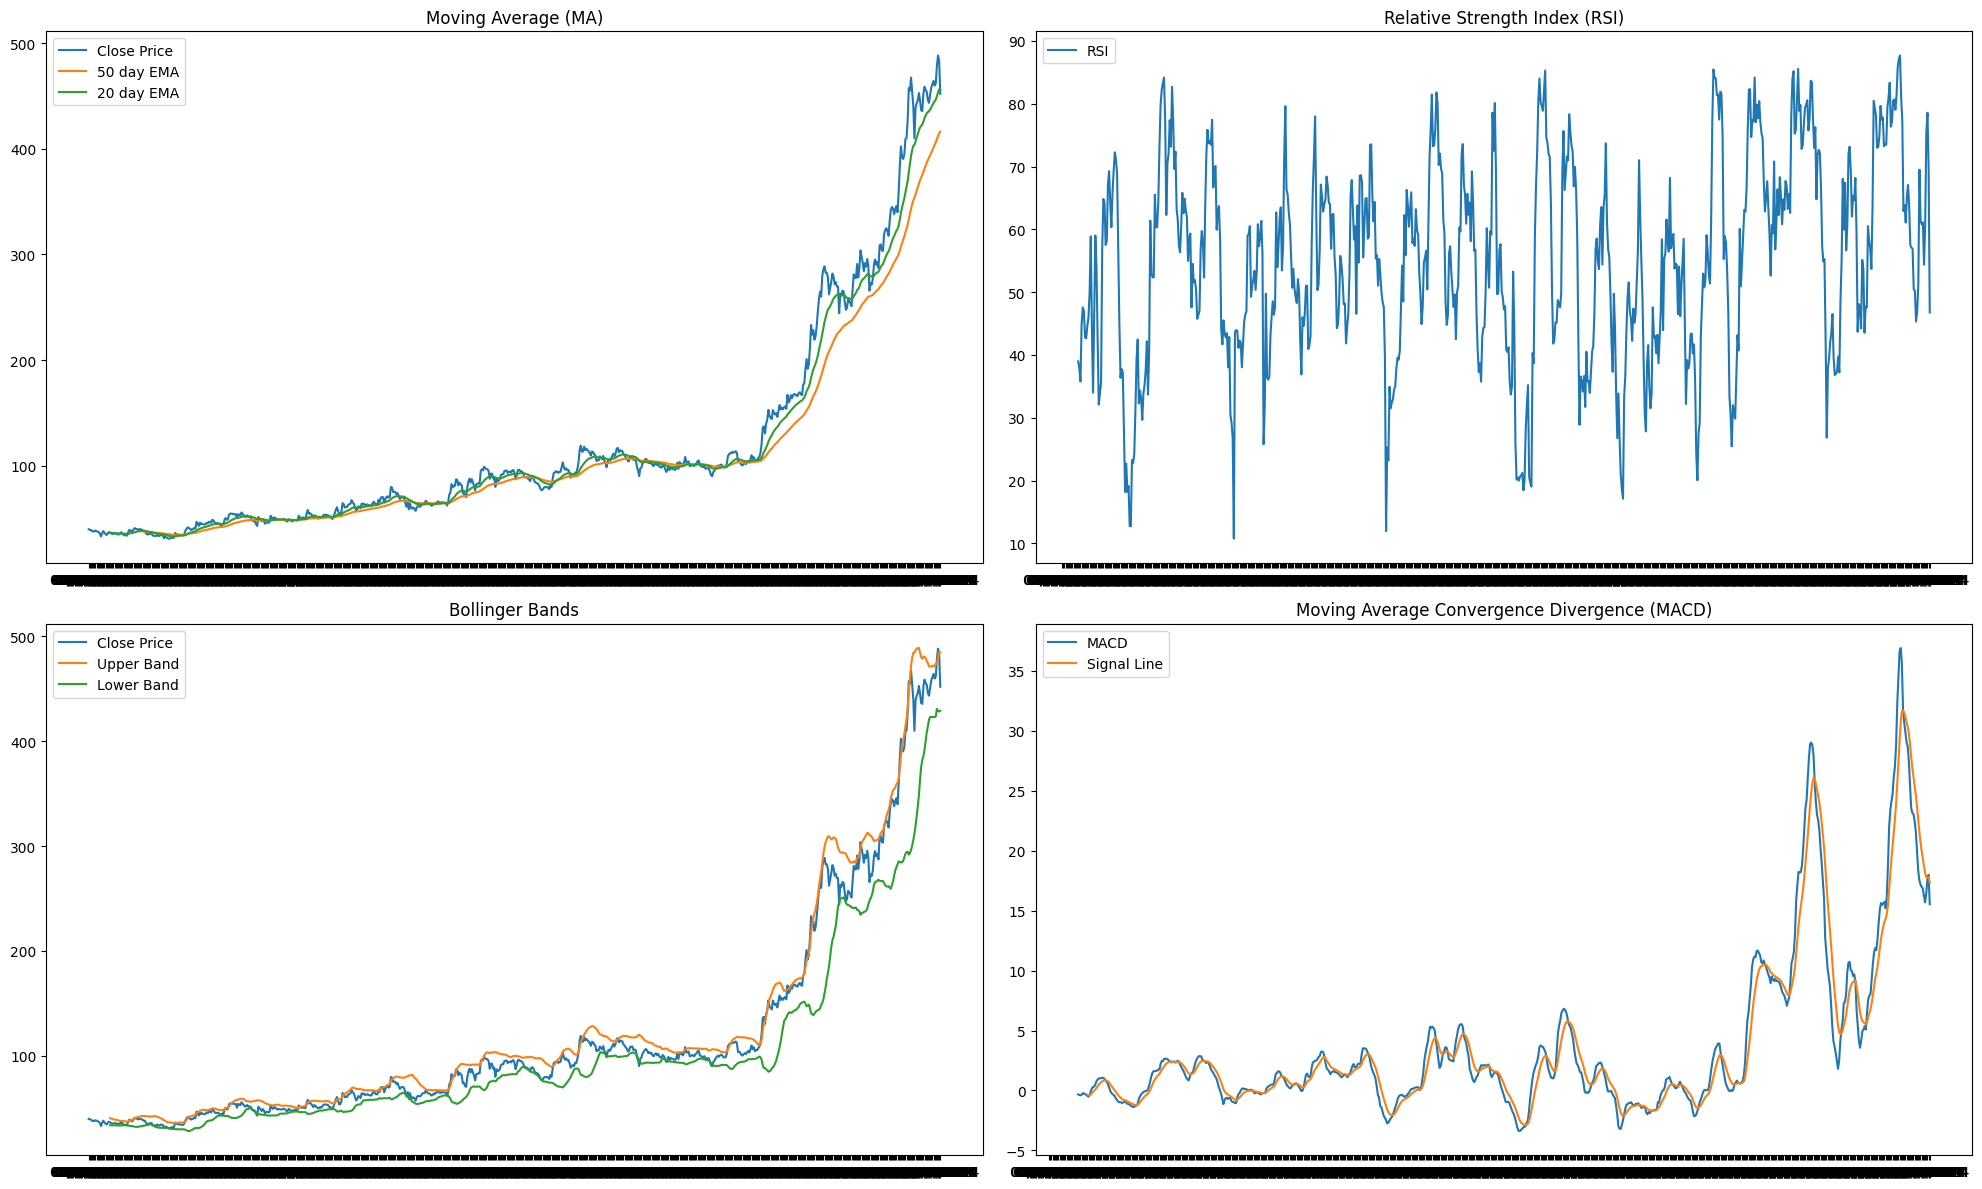

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.plot(df_reversed['Date'], df_reversed['Price'], label='Close Price')
plt.plot(df_reversed['Date'], df_reversed['EMA'], label= '50 day EMA')
plt.plot(df_reversed['Date'], df_reversed['EMA20'], label= '20 day EMA')
plt.title('Moving Average (MA)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df_reversed['Date'], df_reversed['RSI'], label='RSI')
plt.title('Relative Strength Index (RSI)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df_reversed['Date'], df_reversed['Price'], label='Close Price')
plt.plot(df_reversed['Date'], df_reversed['bb'], label='Upper Band')
plt.plot(df_reversed['Date'], df_reversed['lower_band'], label='Lower Band')
plt.title('Bollinger Bands')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df_reversed['Date'], df_reversed['MACD'], label='MACD')
plt.plot(df_reversed['Date'], df_reversed['signal'], label='Signal Line')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.legend()

plt.tight_layout()
plt.show()

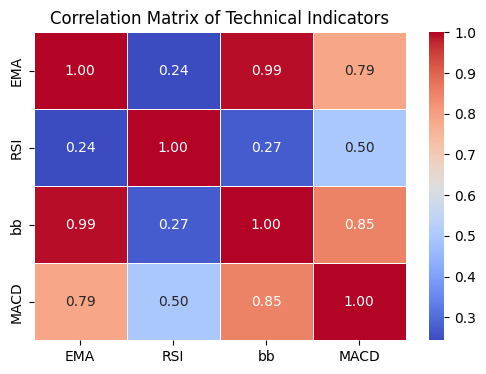

In [ ]:
# Extract relevant columns for correlation analysis
correlation_data = df_reversed[['EMA', 'RSI', 'bb', 'MACD']]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot correlation matrix as a heatmap
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


In [ ]:
df_reversed.corr()['Price'].sort_values(ascending=False)

<ipython-input-377-5521de972bc0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_reversed.corr()['Price'].sort_values(ascending=False)


Price         1.000000
bb            0.996919
EMA20         0.996047
SMA20         0.993947
EMA           0.991846
SMA           0.987764
lower_band    0.979093
signal        0.872119
MACD          0.853086
RSI           0.315267
histogram     0.073785
Name: Price, dtype: float64

In [ ]:
# Calculate absolute correlation coefficients as weights
weights = correlation_matrix.abs().mean()

# Normalize weights to ensure they sum up to 1
weights /= weights.sum()

weighted_sum = (df_reversed * weights).sum(axis=1)
weights /= weights.sum()

In [ ]:
print("Weights for each component:")
print(weights)

Weights for each component:
EMA     0.267837
RSI     0.178439
bb      0.275920
MACD    0.277804
dtype: float64


# Calculating the ideal Long/Short signal where 1 represents Long and -1 represents Short

In [ ]:
df_signal = pd.DataFrame(np.where(df_reversed['Price'].shift(-1) > df_reversed['Price'], 1, -1) , columns = ['actual'])

# Calculating the Long/Short signal as indicated by EMA

In [ ]:
df_signal['EMA'] = np.where(df_reversed['EMA20'] > df_reversed['EMA'], 1, -1)
df_signal

,actual,EMA
0,-1,-1
1,-1,-1
2,-1,-1
3,1,-1
4,-1,-1
...,...,...
754,1,1
755,1,1
756,-1,1
757,-1,1


# Calculating the Long/Short signal as indicated by MACD

In [ ]:
df_signal['MACD'] = np.where(df_reversed['MACD'] > df_reversed['signal'], 1, -1)
df_signal

,actual,EMA,MACD
0,-1,-1,-1
1,-1,-1,-1
2,-1,-1,-1
3,1,-1,-1
4,-1,-1,-1
...,...,...,...
754,1,1,-1
755,1,1,-1
756,-1,1,-1
757,-1,1,1


# Calculating the Long/Short signal as indicated by Bollinger Bands

In [ ]:
df_signal['BB']= np.zeros
for i in range(0, df_reversed.shape[0] ):
  if(df_reversed['Price'][i] >= df_reversed['bb'][i]):
    df_signal['BB'][i] = -1
  else:
    df_signal['BB'][i] = 1

df_signal

<ipython-input-383-c97df169ea07>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['BB'][i] = 1
<ipython-input-383-c97df169ea07>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['BB'][i] = -1


,actual,EMA,MACD,BB
0,-1,-1,-1,1
1,-1,-1,-1,1
2,-1,-1,-1,1
3,1,-1,-1,1
4,-1,-1,-1,1
...,...,...,...,...
754,1,1,-1,1
755,1,1,-1,-1
756,-1,1,-1,-1
757,-1,1,1,1


# Calculating the Long/Short signal as indicated by Relative Strength Index

In [ ]:
df_signal['RSI']= np.zeros

for i in range(0, df_reversed.shape[0] ):
  if(df_reversed['RSI'][i] >= 70):
    df_signal['RSI'][i] = -1
  elif(df_reversed['RSI'][i] <= 30):
    df_signal['RSI'][i] = 1
  else:
    df_signal['RSI'][i] = 1

df_signal['RSI'].value_counts()

<ipython-input-384-a2ac2acce6b7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['RSI'][i] = 1
<ipython-input-384-a2ac2acce6b7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['RSI'][i] = -1
<ipython-input-384-a2ac2acce6b7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal['RSI'][i] = 1


 1    615
-1    144
Name: RSI, dtype: int64

# weighted average indicator using linear combination

In [ ]:
df_signal['combined_indicator'] = weights['EMA']*df_signal['EMA'] + weights['RSI']*df_signal['RSI'] + weights['MACD']*df_signal['MACD'] + weights['bb']*df_signal['BB']

df_signal

,actual,EMA,MACD,BB,RSI,combined_indicator
0,-1,-1,-1,1,1,-0.091282
1,-1,-1,-1,1,1,-0.091282
2,-1,-1,-1,1,1,-0.091282
3,1,-1,-1,1,1,-0.091282
4,-1,-1,-1,1,1,-0.091282
...,...,...,...,...,...,...
754,1,1,-1,1,1,0.444392
755,1,1,-1,-1,-1,-0.464326
756,-1,1,-1,-1,-1,-0.464326
757,-1,1,1,1,1,1.0


In [ ]:
df_signal['combined_indicator'] = np.where(df_signal['combined_indicator'] > 0, 1, -1)

df_signal['combined_indicator'].value_counts()

 1    632
-1    127
Name: combined_indicator, dtype: int64

In [391]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(df_signal['actual'], df_signal['combined_indicator'])
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 78.37%


In [ ]:
df_reversed1['combined_indicator_signal'] = np.where(df_signal['combined_indicator'] > 0, 'L', 'S' )

In [ ]:
df_reversed1.to_csv('final.csv')